# Introduction to PyTorch

## How to create tensors?

    All of deep learning is computations on tensors, which are generalizations of a matrix that can be indexed in more than 2 dimensions.
    So, let's look at how to create tensors, some operations on them.

In [1]:
%pylab inline

import torch

Populating the interactive namespace from numpy and matplotlib


    The main way to create a tensor is to initialise it from an existing list or `numpy.ndarray`

In [2]:
l = [1, 2, 3, 4, 5]
l_tensor = torch.tensor(l)
print(l_tensor)

l_numpy = np.array(l)
l_tensor = torch.from_numpy(l_numpy)
print(l_tensor)

tensor([1, 2, 3, 4, 5])
tensor([1, 2, 3, 4, 5])


     But in real life you usually create the tensors you need directly in `pytorch` without any extra memory allocation.
     There are so many ways to do this and let's look at some of them

In [3]:
x = torch.arange(10)
x

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    We can see the type of elements in the tensor, its size, the number of dimensions in it and much more

In [4]:
print(f"type of elements: {x.dtype}")
print(f"size (or shape) : {x.size()}")
print(f"number of dim: {x.dim()}")

type of elements: torch.int64
size (or shape) : torch.Size([10])
number of dim: 1


    Apart from `torch.arange` we can create a tensor of all zeros, ones or just random from some distribution

In [5]:
# Set the desired tensor size (or shape)
desired_shape = (1, 5, 10)

ones_tensor = torch.ones(desired_shape)
zeros_tensor = torch.zeros(desired_shape)

# each element of the tensor is sampled from a normal standard distribution
random_tensor = torch.randn(desired_shape)

In [6]:
print(random_tensor)
print(random_tensor.shape)

tensor([[[ 1.9585e-01, -6.1831e-01, -9.5756e-01,  3.9901e-01,  9.7058e-01,
           1.2543e-01, -1.3706e+00, -2.4149e-03,  3.2547e+00, -5.4886e-01],
         [ 3.9639e-02,  3.1375e-01,  1.2110e+00, -7.2277e-01,  1.3573e+00,
           1.3111e+00, -3.7105e-02, -1.3918e+00,  1.2738e+00, -4.9734e-02],
         [ 1.9835e+00, -6.2938e-01, -4.9263e-01, -1.0369e-01, -1.5734e+00,
          -1.3818e+00, -7.6623e-03,  8.4458e-02, -6.8961e-01, -7.7442e-01],
         [-4.4600e-01,  2.4276e+00, -7.7969e-01, -8.7114e-01, -8.3761e-02,
           8.7588e-01, -2.0866e-01, -4.6978e-01,  2.9023e-03, -1.1727e+00],
         [ 2.1426e-01,  7.1265e-01,  3.0820e-01,  2.5808e-01, -5.4970e-01,
          -2.0470e+00, -1.2749e+00, -5.7189e-02,  3.3236e-01, -8.0916e-01]]])
torch.Size([1, 5, 10])


## How to change shape of tensor?

    There are several ways to resize the tensors

In [7]:
tensor = torch.arange(100)

print(tensor.shape)
print(tensor)

torch.Size([100])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


    Now we would like to create a 10x10 matrix from the `tensor'

In [8]:
matrix = tensor.reshape(10, 10)

print(matrix.shape)
print(matrix)

torch.Size([10, 10])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])


    What if we want a tenson of order 3 with dimensions 2x10x5?

In [9]:
tensor_3d = tensor.reshape(2, 10, 5)

print(tensor_3d.shape)
print(tensor_3d)

torch.Size([2, 10, 5])
tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34],
         [35, 36, 37, 38, 39],
         [40, 41, 42, 43, 44],
         [45, 46, 47, 48, 49]],

        [[50, 51, 52, 53, 54],
         [55, 56, 57, 58, 59],
         [60, 61, 62, 63, 64],
         [65, 66, 67, 68, 69],
         [70, 71, 72, 73, 74],
         [75, 76, 77, 78, 79],
         [80, 81, 82, 83, 84],
         [85, 86, 87, 88, 89],
         [90, 91, 92, 93, 94],
         [95, 96, 97, 98, 99]]])


    Sometimes we want to swap dimensions, e.g. from 2x10x5 we want to get 5x10x2

In [10]:
tensor_3d_v2 = tensor_3d.transpose(dim0=0, dim1=2)
print(tensor_3d_v2.shape)

# or this way. it helps not to make a mistake
tensor_3d_v3 = tensor_3d.transpose(dim0=0, dim1=-1)
print(tensor_3d_v3.shape)

# or this way
tensor_3d_v4 = tensor_3d.permute(2, 1, 0)
print(tensor_3d_v4.shape)

torch.Size([5, 10, 2])
torch.Size([5, 10, 2])
torch.Size([5, 10, 2])


    You also able to add imagine dimension. It is often useful

In [11]:
unsqueezed_tensot = tensor.unsqueeze(0)
print(unsqueezed_tensot.shape)

torch.Size([1, 100])


    And in fact, there are many other useful functions that often come in handy.
    For example, `.chunk`, `.unfold`, `.flatten`, `.scatter`, `.gather`, ....
    
    So, feel free to dive into the PyTorch documentation and find out more yourself :)

## Operations on tensors

    In general, PyTorch has all the same things as NumPy and maybe even a little more
    Let's look at the aggregating functions

In [12]:
tensor = torch.randn(10, 100, 1000)
print(tensor.shape)

torch.Size([10, 100, 1000])


In [13]:
tensor.mean(), tensor.sum(), tensor.max(), tensor.min()

(tensor(0.0014), tensor(1377.3700), tensor(4.8508), tensor(-5.1751))

    Note, that almost every aggregation function has argument `dim` and `keepdim`

In [14]:
# take mean over 0 dimension
print(tensor.mean(dim=0).shape)

# or over 0 and 1 dimensions
print(tensor.mean(dim=(0, 1)).shape)

torch.Size([100, 1000])
torch.Size([1000])


In [15]:
# take mean over 0 and 2 dimensions and keep dimensions
print(tensor.mean(dim=(0, 2), keepdim=True).shape)

torch.Size([1, 100, 1])


In [16]:
# Frobenius norm
print(tensor.norm(p='fro'))

tensor(1000.4949)


    Linear algrebra is also arranged very similarly to NumPy

In [17]:
A = torch.randn(10, 20)
B = torch.randn(20, 30)

In [18]:
C = A.matmul(B)

# or
C = A @ B

# or
C = torch.matmul(A, B)

## Automatic Differentiation Engine

    Gradient automatic computation using backpropagation:
        1) Create a tensor/tensors which requires gradient: a = torch.tensor(..., requires_grad=True)
        2) Define some differentiable scalar function loss = whatever(a)
        3) Request backward pass loss.backward()
        4) The gradient is available as a.grad
        
    Note the loss must be a function of at least one tensor which requires gradient.
    For more information see https://pytorch.org/docs/stable/autograd.html



    Let's look on a simple example

In [19]:
x = torch.randn(4, requires_grad=True)
y = torch.randn(4, requires_grad=True)
z = x * y + 10
p = z.sum()
p.backward()
print('x:', x.data)
print('y:', y.data)
print('dp / dx:', x.grad)
print('dp / dy:', y.grad)

x: tensor([-0.9663, -0.0527, -0.4354, -0.0563])
y: tensor([ 0.5330, -1.4276, -0.8498,  0.5343])
dp / dx: tensor([ 0.5330, -1.4276, -0.8498,  0.5343])
dp / dy: tensor([-0.9663, -0.0527, -0.4354, -0.0563])


    Detaching variables. .detach() returns a copy of a variable, through which backpropagation doesn't pass.
    If you average or just store batch losses during the optimization, you'd better detach those losses before averaging or storing.
    Otherwise the computational graphs for each batch would be stored in memory as well as batch losses, so you run out of memory very fast.
    
    Also there is in-place version (.detach_()) which doesn't create detached copy of the variable, but detach variable itself from its computational graph.

In [20]:
x = torch.randn(4, requires_grad=True)
y0 = torch.randn(4, requires_grad=True)
y = y0.detach()
z = x * y + 10
p = z.sum()
p.backward()
print('x:', x.data)
print('y:', y.data)
print('dp / dx:', x.grad)
print('dp / dy:', y.grad)

x: tensor([-1.4108,  1.2233, -0.3430,  0.8104])
y: tensor([-1.1435,  0.8602, -1.2313,  0.0317])
dp / dx: tensor([-1.1435,  0.8602, -1.2313,  0.0317])
dp / dy: None


    You can also reset the gradient of a specific variable

In [21]:
x = torch.tensor([1., 1, 1, 1], requires_grad=True)
y = x ** 2
p = y.sum()
p.backward()
print('x:', x)
print('dp / dx:', x.grad)
y = 1 / x
p = y.sum()
p.backward()
print('x:', x)
print('dp / dx:', x.grad)

x: tensor([1., 1., 1., 1.], requires_grad=True)
dp / dx: tensor([2., 2., 2., 2.])
x: tensor([1., 1., 1., 1.], requires_grad=True)
dp / dx: tensor([1., 1., 1., 1.])


In [22]:
x = torch.tensor([1, 1, 1, 1.], requires_grad=True)
y = x ** 2
p = y.sum()
p.backward()
print('x:', x)
print('dp / dx:', x.grad)
x.grad.zero_()         # zero gradinents
y = 1 / x
p = y.sum()
p.backward()
print('x:', x)
print('dp / dx:', x.grad)

x: tensor([1., 1., 1., 1.], requires_grad=True)
dp / dx: tensor([2., 2., 2., 2.])
x: tensor([1., 1., 1., 1.], requires_grad=True)
dp / dx: tensor([-1., -1., -1., -1.])


    For memory saving, gradients are stored only for so called leaf-variables.

In [23]:
# Don't pay attention on UserWarning from Python

x = torch.randn(4, requires_grad=True)  # leaf variable
y = x + 1                               # not a leaf variable
p = y.sum()                             # not a leaf variable
p.backward()
print('x:', x)
print('y:', y)
print('p:', p)
print('x.grad:', x.grad)
print('y.grad:', y.grad)
print('p.grad:', p.grad)

x: tensor([ 0.5853,  1.0700, -1.2298,  1.1589], requires_grad=True)
y: tensor([ 1.5853,  2.0700, -0.2298,  2.1589], grad_fn=<AddBackward0>)
p: tensor(5.5844, grad_fn=<SumBackward0>)
x.grad: tensor([1., 1., 1., 1.])
y.grad: None
p.grad: None


/Users/markaa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  # This is added back by InteractiveShellApp.init_path()
/Users/markaa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/py

In [24]:
x = torch.randn(4, requires_grad=True)  # leaf variable
y = torch.randn(4, requires_grad=True)  # leaf variable
z = x + y    # not a leaf variable
p = z.sum()  # not a leaf variable
p.backward()
print('x.grad:', x.grad)
print('y.grad:', y.grad)
print('z.grad:', z.grad)
print('p.grad:', p.grad)
print('x.is_leaf:', x.is_leaf)
print('y.is_leaf:', y.is_leaf)
print('z.is_leaf:', z.is_leaf)
print('p.is_leaf:', p.is_leaf)

x.grad: tensor([1., 1., 1., 1.])
y.grad: tensor([1., 1., 1., 1.])
z.grad: None
p.grad: None
x.is_leaf: True
y.is_leaf: True
z.is_leaf: False
p.is_leaf: False


/Users/markaa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  
/Users/markaa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if __name__ == 

    One can use .retain_grad() to save gradients for non-leaf variables.

In [25]:
x = torch.randn(4, requires_grad=True)   # leaf variable
z = torch.randn(4, requires_grad=True)   # leaf variable
w = z * 2      # not a leaf variable
y = x * w + 1  # forward pass before retaining gradient is ok
p = y.sum()

w.retain_grad()

p.backward()
print('dp / dx:', x.grad)
print('dp / dz:', z.grad)
print('dp / dw:', w.grad)

dp / dx: tensor([-3.0129,  1.4726, -1.1907,  1.3036])
dp / dz: tensor([ 0.7252,  0.6488, -0.6153, -2.9357])
dp / dw: tensor([ 0.3626,  0.3244, -0.3077, -1.4678])


    Note that even if there are non-leaf varibales which require gradient in the computational graph, .backward() fail.
    For correct work one of the leaf variables must require gradient.

In [26]:
# will not work
x = torch.randn(4, requires_grad=False)   # leaf variable
z = torch.randn(4, requires_grad=False)   # leaf variable
w = z * 2      # not a leaf variable
y = x * w + 1  # forward pass before retaining gradient is ok
p = y.sum()

w.retain_grad()

p.backward()

RuntimeError: can't retain_grad on Tensor that has requires_grad=False

## Dataset API
    PyTorch provides convenient functionality for working with data during neural network training.

In [27]:
from torch.utils.data import DataLoader, Dataset

    The `Dataset` is a class that initiates our data somehow in the constructor.
    It also has two main methods __getitem__ and __len__.
    Let's make a simple dataset, where one element is a vector of size 10

In [28]:
class SimpleDataset(Dataset):
    
    def __init__(self, data: torch.Tensor):
        self.data = data
    
    def __getitem__(self, index: int):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [29]:
example_data = torch.randn(1000, 10)
simple_dataset = SimpleDataset(example_data)

In [30]:
simple_dataset[10]

tensor([ 2.5797,  0.5153, -1.8101, -0.2936, -2.2498,  1.5486,  0.1375, -1.7653,
         0.7241,  1.1529])

In [31]:
len(simple_dataset)

1000

    Second important class is `Dataloader`.
    It takes some objects from the dataset and gather them into a batch.

In [32]:
simple_dataloader = DataLoader(simple_dataset, batch_size=10)

    Note that `simple_dataloader` is an iterator and has not yet done anything with the data.
    Let's take a look at the first batсh

In [33]:
from itertools import islice

first_batch = list(islice(simple_dataloader, 0, 1))[0]

In [34]:
print(first_batch.shape)
print(first_batch)

torch.Size([10, 10])
tensor([[ 4.7640e-01, -2.4392e-01, -3.0228e-01,  2.4409e-01,  1.1879e+00,
          6.1010e-01, -6.1443e-01,  6.6263e-01,  1.0846e-01, -2.8123e-01],
        [ 1.6125e+00, -5.3476e-01, -3.0822e-01,  3.6862e-01, -5.0913e-01,
         -5.8651e-01, -2.1725e-01,  1.9400e-01, -6.9170e-01,  1.5447e+00],
        [-2.0479e+00,  6.6786e-01,  1.1241e+00,  5.4351e-01, -7.5457e-01,
         -1.5541e+00, -1.8343e+00, -5.0052e-01, -5.3663e-02, -1.1224e+00],
        [ 5.5327e-01, -4.0333e-01,  1.0972e+00, -5.6430e-01, -1.4030e+00,
         -2.0434e+00,  8.4237e-02,  1.3065e+00,  6.5699e-01,  3.9171e-01],
        [-1.8678e-01, -2.0547e+00, -1.7454e-01, -3.5228e-01, -8.0769e-02,
         -6.1941e-01, -9.3604e-01, -1.0666e+00,  1.9389e+00,  4.4494e-01],
        [ 6.2038e-02, -7.4033e-01, -3.9782e-01,  1.7042e+00, -9.0481e-01,
          1.2189e+00, -1.3114e+00, -1.7935e+00, -2.7893e-01,  1.0207e+00],
        [ 1.8920e-01, -3.2648e-01, -1.4454e+00,  9.2502e-01,  8.5233e-01,
         -2

    DataLoader has many arguments for detailed configuration. Check the documentation so you can use it in the future

## Optimization

    Let's use optimization in PyTorch to find minimum of some simple function

In [35]:
import time
from IPython import display

In [36]:
def func(x):
    return (x - 10) ** 2 + 14

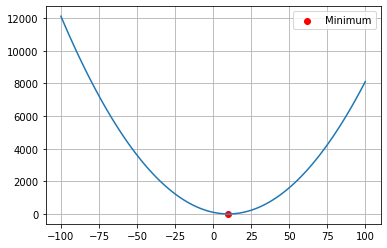

In [37]:
x = torch.linspace(-100, 100, 100)
y = func(x)

plt.plot(x, y)
plt.scatter([10], [14], label='Minimum', c='red')
plt.legend()
plt.grid()
plt.show()

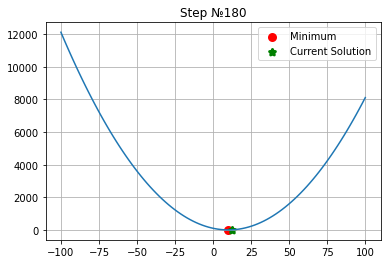

In [38]:
# requires_grad=True is required
current_solution = torch.tensor([100.], requires_grad=True)

# initialize a simple SGD
# SGD will minimize только одну переменную — current_solution
optimizer = torch.optim.SGD([current_solution], 1e-2)

NUM_STEP = 200


for i in range(NUM_STEP):
    current_loss = func(current_solution)
    
    # zero out .grad of `current_solution`
    optimizer.zero_grad()
    
    # compute new gradiat by `current_solution`
    current_loss.backward()
    
    # update current_solution
    optimizer.step()
    
    if i % 20 == 0:
        display.clear_output()
        
        x = torch.linspace(-100, 100, 100)
        y = func(x)

        plt.plot(x, y)
        plt.scatter([10], [14], label='Minimum', c='red', linewidths=3)
        plt.scatter([current_solution.item()], [current_loss.item()],
                    label='Current Solution', marker='*', c='green', linewidths=3)
        
        plt.legend()
        plt.grid()
        plt.title(f'Step №{i}')
        plt.show()
        
        time.sleep(1)